In [1]:
# Numpy and pandas for manipulating the data
import numpy as np
import pandas as pd

# Matplotlib and seaborn for visualization
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

# Performance metrics from sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# Statsmodel for modeling trends
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

# Prophet for time forecasting
from fbprophet import Prophet

# To hide stdout because Prophet can be loud
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

/home/jshuai/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Read in the file
by_date_total_file = './data/cleaned/by_date_total.csv'
by_date_total_df = pd.read_csv(by_date_total_file, parse_dates=True, index_col=0)

In [3]:
# Styling
# make figures bigger
mpl.rcParams['figure.figsize'] = 12, 8

# change grid line styling
mpl.rcParams['grid.color'] = '#d6dbdf'
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['grid.linewidth'] = 0.5

# change font
mpl.rcParams['font.family'] = 'Open Sans'

mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=['#6377cb', '#b9bac2'])

In [4]:
def train_prophet(time_series, start=12):
    """Trains the prophet model, making predictions on each value 
    """
    time_series = time_series.reset_index()
    time_series.columns = ['ds', 'y']
    predictions = []
    for i in list(time_series.index)[start:-1]:
        model = Prophet(yearly_seasonality=True)
        model = model.fit(time_series[:i + 2])
        future = model.make_future_dataframe(periods=1)
        output = model.predict(future)
        predictions.append(output.tail(1)[['ds', 'yhat', 'yhat_upper', 'yhat_lower']])

    predictions = pd.concat(predictions).set_index('ds')
    
    return predictions

def plot_predictions(truth, predictions):
    """Plots the truth alongside the predictions and visualize how good the time forecasting model is.
    """
    truth.plot(color='g', label='truth')
    predictions['yhat'].plot(label='predictions')
    predictions['yhat_upper'].plot(color='r', alpha=0.3, ls='--')
    predictions['yhat_lower'].plot(color='r', alpha=0.3, ls='--')
    plt.legend()
    plt.show()

### Weekly Time Series

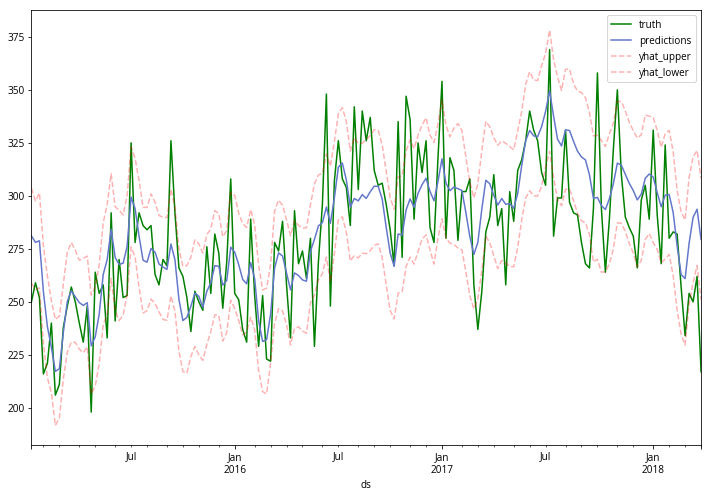

MSE: 532.7585874126362
Aggregated Monthly: 22289.256238123635


In [5]:
# Get weekly time series
start=52
time_series = by_date_total_df.resample('W').sum().sum(axis=1)
time_series.index = pd.to_datetime(time_series.index)
truth = time_series[start + 1:]

# Make predictions and plot
predictions = train_prophet(time_series, start=start)
plot_predictions(truth, predictions)

# Calculate MSE
print("MSE: {}".format(mean_squared_error(truth, predictions['yhat'])))
print("Aggregated Monthly: {}".format(
    mean_squared_error(truth.resample('M').sum(), predictions['yhat'].resample('M').sum())))

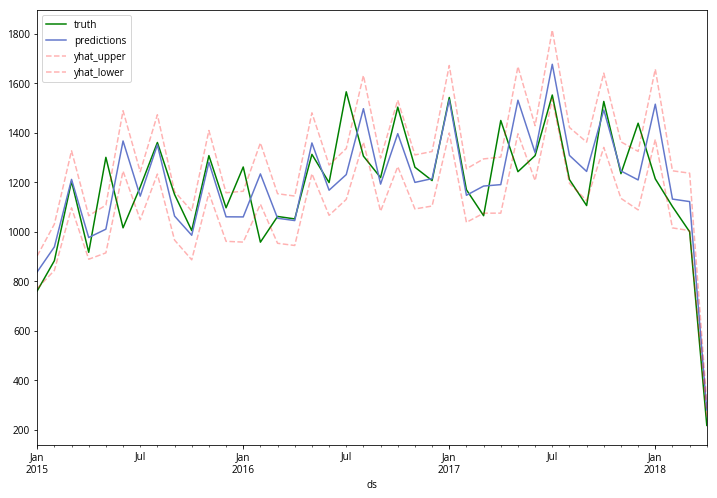

In [6]:
resampled_truth = truth.resample('M').sum()
resampled_preds = predictions.resample('M').sum()

plot_predictions(resampled_truth, resampled_preds)

### Log Weekly Time Series

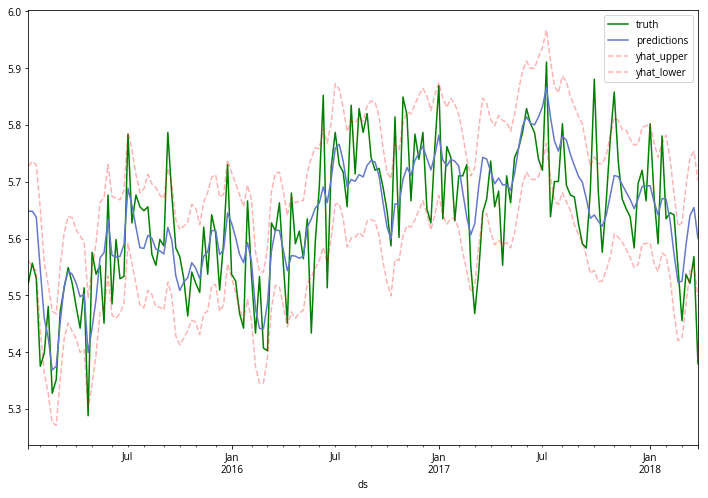

MSE: 0.00587957204260729
Aggregated Monthly: 1410962.8599720537


In [7]:
# Get weekly time series
start=52
time_series = by_date_total_df.resample('W').sum().sum(axis=1)
time_series.index = pd.to_datetime(time_series.index)
truth = time_series[start + 1:]

# Log transform time_series y
time_series = np.log(time_series)

# Make predictions and plot
predictions = train_prophet(time_series, start=start)
plot_predictions(np.log(truth), predictions)

# Calculate MSE
print("MSE: {}".format(mean_squared_error(np.log(truth), predictions['yhat'])))
print("Aggregated Monthly: {}".format(
    mean_squared_error(truth.resample('M').sum(), predictions['yhat'].resample('M').sum())))

### Bi-Weekly Time Series

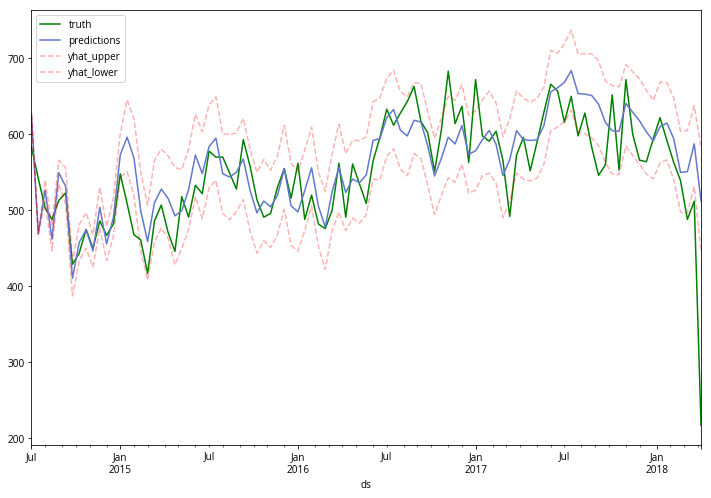

2277.8146045008966

In [8]:
# Get monthly time series
start = 12
time_series = by_date_total_df.resample('2W').sum().sum(axis=1)
time_series.index = pd.to_datetime(time_series.index)
truth = time_series[start + 1:]

# Make predictions and plot
predictions = train_prophet(time_series, start=start)
plot_predictions(truth, predictions)

# Calculate MSE
mean_squared_error(truth, predictions['yhat'])

In [9]:
# Try to do the most you can with predictions!!!
# predictions.resample('M').sum()['yhat']
# by_date_total_df.resample('M').sum().sum(axis=1)